In [1]:
import os
import sys
from datetime import datetime
from IPython.display import HTML

import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

WIDTH = 1100
pd.options.display.float_format = 'R$ {:,.2f}'.format

caminho_commons = os.path.join('../..', '..', 'ajna_docs', 'commons')
caminho_virasana = os.path.join('../..', '..', 'ajna_docs', 'virasana')
sys.path.append(caminho_commons)
sys.path.append('../..')
sys.path.append(caminho_virasana)

from ajna_commons.flask.conf import DATABASE, MONGODB_URI

from bhadrasana.models import engine


def AnoMes(row):
    return str(row.Ano) + str(row['Mês']).zfill(2)


2024-02-19 09:49:06,934 ajna         INFO     Configuração de log efetuada


Fazendo log de erros e alertas no arquivo  ../..\..\ajna_docs\commons\ajna_commons\flask\error.log
Fazendo log de atividade no arquivo  ../..\..\ajna_docs\commons\ajna_commons\flask\access.log


# Colocar os códigos embaixo

In [108]:
def group_by_day(df, ano, mes):
    df = df[['codigoRecinto', 'dataHoraTransmissao']]
    # Filtrando os dados apenas para o ano e mês
    df_ano_mes = df[(df['dataHoraTransmissao'].dt.year == ano) & (df['dataHoraTransmissao'].dt.month == mes)]
    # Agrupando por 'CodigoRecinto' e 'dataTransmissao' e contando o número de registros
    return df_ano_mes.groupby(['codigoRecinto', df_ano_mes['dataHoraTransmissao'].dt.date]).size().reset_index(name='count')

def plot_(grouped, ano, mes):
    dias = pd.Series(grouped.dataHoraTransmissao.unique(), name='dataHoraTransmissao')
    # Para cada 'CodigoRecinto', plote um gráfico de linhas
    plt.figure(figsize=(15, 6))
    for codigo_recinto in grouped['codigoRecinto'].unique():
        data = grouped[grouped['codigoRecinto'] == codigo_recinto]
        data = data.merge(dias, how='right').fillna({'count': 0, 'codigoRecinto': codigo_recinto})
        data = data.sort_values('dataHoraTransmissao')
        ax = plt.plot(data['dataHoraTransmissao'], data['count'], label=codigo_recinto)

    # Adicionando título e legendas aos eixos
    plt.title(f'Quantidade de registros por dia - {mes}/{ano}')
    plt.xlabel('Data')
    plt.ylabel('Quantidade de registros')
    plt.legend(title='CodigoRecinto')
    plt.xticks(grouped['dataHoraTransmissao'].unique(), rotation=90)  # Rotaciona os rótulos do eixo x para melhor visualização
    return plt

def plot_linhas(df, ano, mes):
    grouped = group_by_day(df, ano, mes)
    return plot_(grouped, ano, mes)

In [3]:
SQL_ACESSOS = '''
SELECT *
FROM dbmercante.apirecintos_acessosveiculo
WHERE YEAR(dataHoraTransmissao)=2024'''

SQL_PESAGENS = '''
SELECT *
FROM dbmercante.apirecintos_pesagensveiculo
WHERE YEAR(dataHoraTransmissao)=2024'''


df_acessos = pd.read_sql(SQL_ACESSOS, engine)
df_pesagens = pd.read_sql(SQL_PESAGENS, engine)

In [124]:
SQL_ESCANEAMENTOS = '''
SELECT *
FROM dbmercante.apirecintos_inspecoesnaoinvasivas
WHERE YEAR(dataHoraTransmissao)=2024'''

df_escaneamentos = pd.read_sql(SQL_ESCANEAMENTOS, engine)

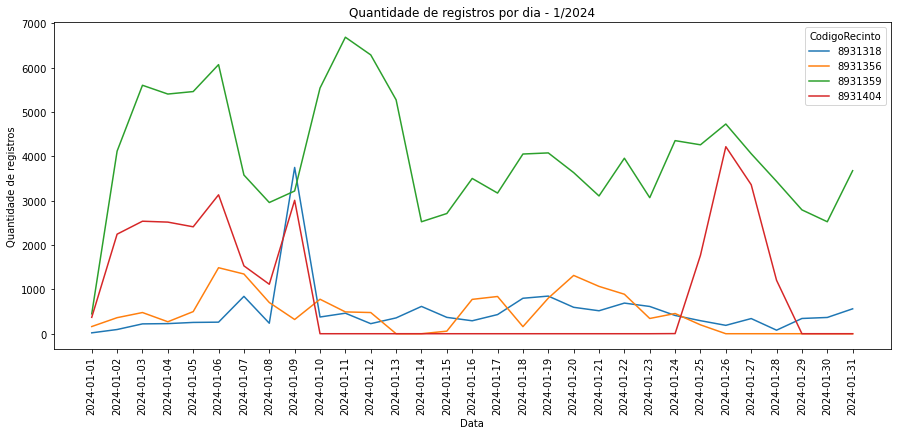

In [109]:
print('ACESSOS')
plot_linhas(df_acessos, 2024, 1).show()

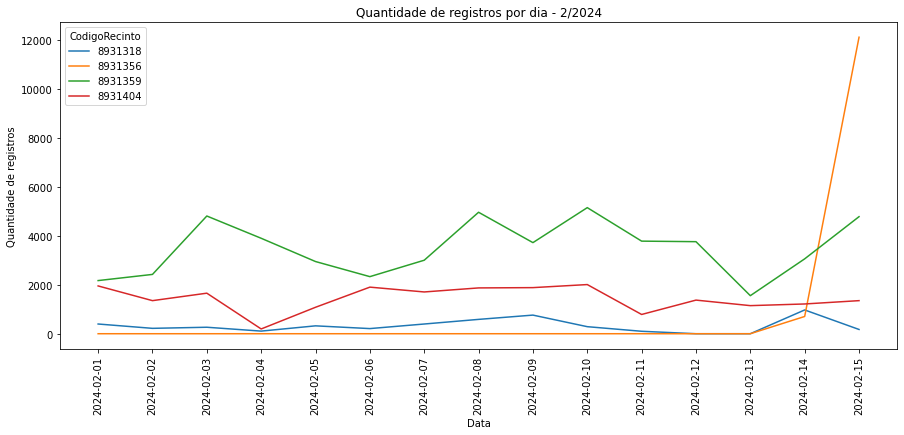

In [110]:
print('ACESSOS')
plot_linhas(df_acessos, 2024, 2).show()

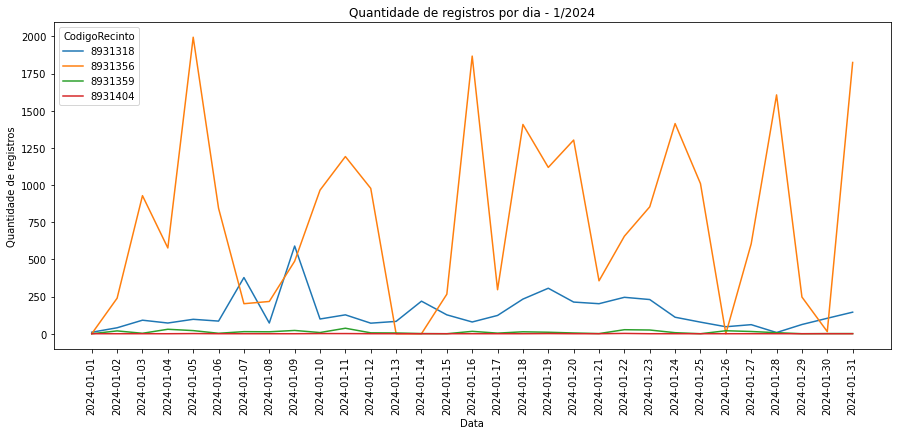

In [111]:
plot_linhas(df_pesagens, 2024, 1).show()

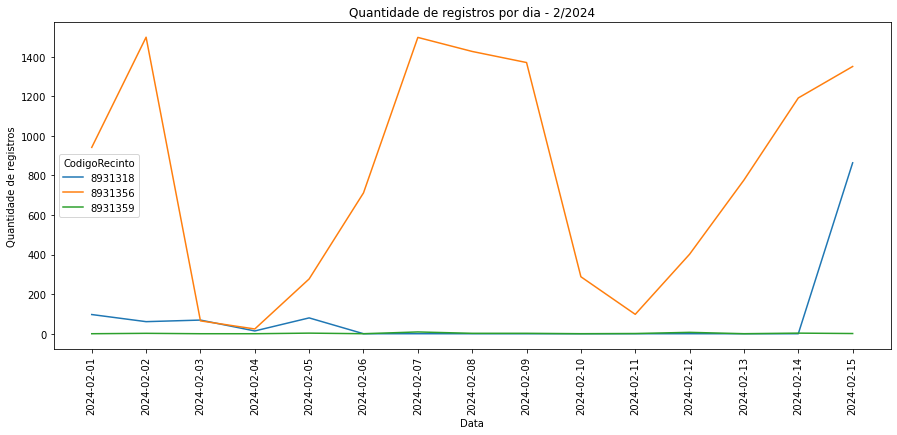

In [112]:
print('PESAGENS')
plot_linhas(df_pesagens, 2024, 2).show()

In [118]:
dias = pd.Series(df_acessos.dataHoraTransmissao.unique(), name='dataHoraTransmissao')
grouped_acessos = df_acessos.groupby(['codigoRecinto', df_acessos['dataHoraTransmissao'].dt.date]).size().reset_index(name='count')
grouped_pesagens = df_pesagens.groupby(['codigoRecinto', df_pesagens['dataHoraTransmissao'].dt.date]).size().reset_index(name='count')

In [119]:
grouped_eventos = grouped_acessos.merge(grouped_pesagens, how='left', on=['codigoRecinto', 'dataHoraTransmissao'])
grouped_eventos = grouped_eventos.fillna(0)
grouped_eventos['count'] = grouped_eventos['count_x'] - grouped_eventos['count_y']

In [120]:
grouped_eventos['dataHoraTransmissao'] = pd.to_datetime(grouped_eventos['dataHoraTransmissao'])

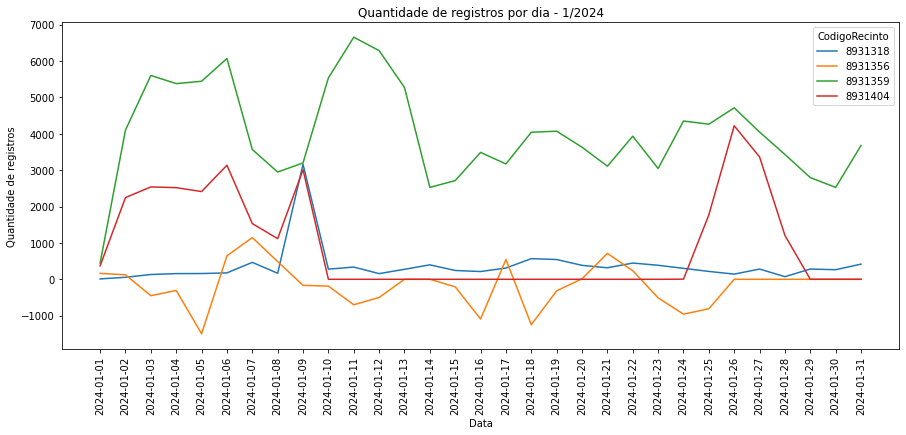

In [121]:
print('"FALTA" DE PESAGENS')
plot_(grouped_eventos[(grouped_eventos['dataHoraTransmissao'].dt.year == 2024) & (grouped_eventos['dataHoraTransmissao'].dt.month == 1)], 2024, 1).show()

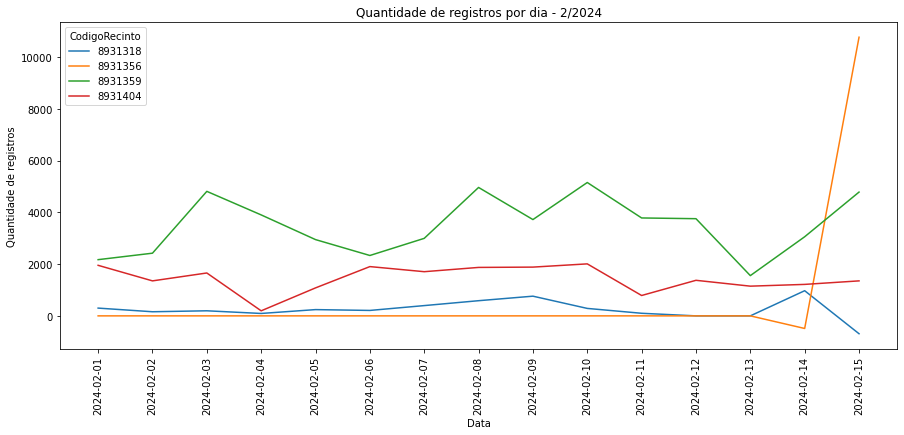

In [122]:
print('"FALTA" DE PESAGENS')
plot_(grouped_eventos[(grouped_eventos['dataHoraTransmissao'].dt.year == 2024) & (grouped_eventos['dataHoraTransmissao'].dt.month == 2)], 2024, 2).show()

In [87]:
import numpy as np
from datetime import timedelta
import time
def seconds_to_datetime(seconds, format='%d dias %H:%M:%S'):
    td = timedelta(seconds=seconds)
    time_obj = time.gmtime(td.total_seconds())
    return time.strftime(format, time_obj)

In [91]:
print('ACESSOS')
df_acessos['delay'] = (df_acessos['dataHoraTransmissao'] - df_acessos['dataHoraOcorrencia']) / np.timedelta64(1, 's')
df_acessos['mes'] = df_acessos['dataHoraTransmissao'].dt.month
print('Tirar um dia, pois dia não pode ser zero, então dia "1" na verdade é o zero')
df_acessos.groupby(['codigoRecinto', 'mes']).delay.mean().apply(lambda x: seconds_to_datetime(x))

Tirar um dia, pois dia não pode ser zero, então dia "1" na verdade é o zero


codigoRecinto  mes
8931318        1      05 dias 05:57:27
               2      02 dias 04:46:03
8931356        1      07 dias 11:36:01
               2      13 dias 13:46:27
8931359        1      01 dias 00:07:46
               2      01 dias 00:00:08
8931404        1      01 dias 12:57:16
               2      01 dias 06:26:37
Name: delay, dtype: object

In [92]:
print('PESAGENS')
df_pesagens['delay'] = (df_pesagens['dataHoraTransmissao'] - df_pesagens['dataHoraOcorrencia']) / np.timedelta64(1, 's')
df_pesagens['mes'] = df_pesagens['dataHoraTransmissao'].dt.month
print('Tirar um dia, pois dia não pode ser zero, então dia "1" na verdade é o zero')
df_pesagens.groupby(['codigoRecinto', 'mes']).delay.mean().apply(lambda x: seconds_to_datetime(x))

Tirar um dia, pois dia não pode ser zero, então dia "1" na verdade é o zero


codigoRecinto  mes
8931318        1      03 dias 07:04:24
               2      05 dias 15:26:41
8931356        1      01 dias 10:15:35
               2      01 dias 01:03:24
8931359        1      01 dias 03:14:55
               2      01 dias 00:00:09
8931404        1      01 dias 00:00:29
Name: delay, dtype: object

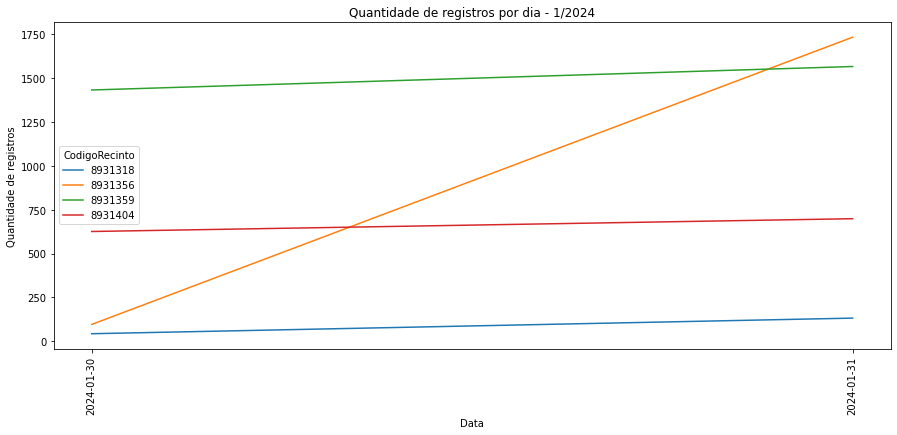

In [125]:
print('ESCANEAMENTOS')
plot_linhas(df_escaneamentos, 2024, 1).show()

ESCANEAMENTOS


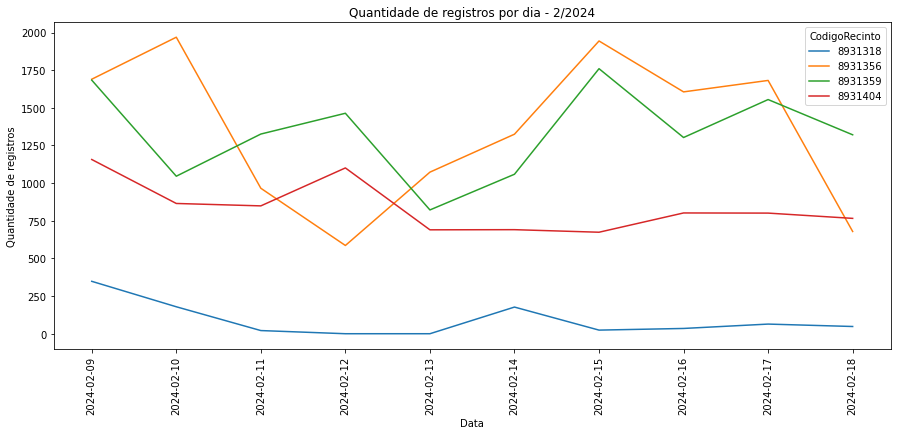

In [128]:
print('ESCANEAMENTOS')
plot_linhas(df_escaneamentos, 2024, 2).show()

In [127]:
df_escaneamentos['delay'] = (df_escaneamentos['dataHoraTransmissao'] - df_escaneamentos['dataHoraOcorrencia']) / np.timedelta64(1, 's')
df_escaneamentos['mes'] = df_escaneamentos['dataHoraTransmissao'].dt.month
print('ESCANEAMENTOS - Tirar um dia, pois dia não pode ser zero, então dia "1" na verdade é o zero')
df_escaneamentos.groupby(['codigoRecinto', 'mes']).delay.mean().apply(lambda x: seconds_to_datetime(x))

Tirar um dia, pois dia não pode ser zero, então dia "1" na verdade é o zero


codigoRecinto  mes
8931318        1      01 dias 00:04:02
               2      01 dias 08:05:08
8931356        1      04 dias 11:02:08
               2      01 dias 01:17:43
8931359        1      01 dias 00:06:10
               2      01 dias 00:00:14
8931404        1      01 dias 06:08:32
               2      01 dias 17:24:58
Name: delay, dtype: object